In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
## 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
## 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
## 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
## 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
## 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [4]:
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
region = 'tibet'
sample_region = 'TIBET'

In [ ]:
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

## 指数的计算
# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def water_index(img):
    image = ee.Image(img).clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

In [ ]:
# for year in range(2000,2021,5):
#     print(year)
#     table = ee.FeatureCollection('users/311605001111/man_sample_1000/'+ sample_region + str(year))
#     print(table.size().getInfo())
#     test_accuracy = table.errorMatrix('label', 'waterclass')
#     print(test_accuracy.getInfo())
#     print('total accuracy:{}'.format(test_accuracy.accuracy().getInfo()))
#     print('kappa:{}'.format(test_accuracy.kappa().getInfo()))

# xin

In [ ]:
def image_accuracy(img):
    image = maskSR(water_index(img)).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')
    manual_point = manual_samples.filter(ee.Filter.eq('Image_id',img.get('system:id'))).map(lambda i : i.centroid())
    inter_points = image.sampleRegions(**{
        'collection': manual_point,
        'properties': ['label'],
        'scale': 30,
        'geometries': True,
    })
    inter_samples = inter_points.map(lambda i : i.setMulti({'Image_id':img.get('system:id')}))
    return inter_samples

# def removeProperty(feat):
#     selectProperties = ee.Feature(feat).propertyNames().filter(ee.Filter.neq('item', 'random')).filter(ee.Filter.neq('item', 'waterclass'))  
#     return feat.select(selectProperties)
def removeProperty(feat):
    selectProperties = ee.Feature(feat).propertyNames().filter(ee.Filter.neq('item', 'random'))
    return feat.select(selectProperties)

In [ ]:
year = '2005'

In [ ]:
# TIME = [['2000','0105'],['2005','0105'],['2010','0610'],['2015','1115'],['2020','1620']]
# TIME = [['2000'],['2005'],['2010'],['2015'],['2020']]

print(year)
## 导入人工采集的样本
manual_samples = ee.FeatureCollection('users/311605001111/manual_samples/' + sample_region +'_' + year)
print('manual-sample number:{}'.format(manual_samples.size().getInfo()))

# 图像集，image_col
image_id = ee.List(manual_samples.distinct('Image_id').aggregate_array('Image_id'))
image_set = ee.List([])
for i in image_id.getInfo():
    if 'LT05' in i:
        image_set = image_set.add(ee.Image(str(i)).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']))
    elif 'LE07' in i:
        image_set = image_set.add(ee.Image(str(i)).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']))
    else:
        image_set = image_set.add(ee.Image(str(i)).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']))
image_col = ee.ImageCollection(image_set)
    
## 导入自动采集的样本
auto_samples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920_v2')
print('auto-sample number:{}'.format(auto_samples.size().getInfo()))
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(auto_samples,label,bands)
SamplePoints = image_col.map(image_accuracy).flatten()
    
sp11 = SamplePoints.filter(ee.Filter.eq('label',0)).filter(ee.Filter.eq('waterclass',0))
wl11 = sp11.randomColumn('random',1,'uniform').sort('random').limit(799)
sp12 = SamplePoints.filter(ee.Filter.eq('label',1)).filter(ee.Filter.eq('waterclass',0))
# print(sp12.size().getInfo())
wl12 = sp12.randomColumn('random',1,'uniform').sort('random').limit(18)
sp21 = SamplePoints.filter(ee.Filter.eq('label',0)).filter(ee.Filter.eq('waterclass',1))
# print(sp21.size().getInfo())
wl21 = sp21.randomColumn('random',1,'uniform').sort('random').limit(1)
sp22 = SamplePoints.filter(ee.Filter.eq('label',1)).filter(ee.Filter.eq('waterclass',1))
wl22 = sp22.randomColumn('random',1,'uniform').sort('random').limit(182)

com_SamplePoints = ee.FeatureCollection([wl11,wl12,wl21,wl22]).flatten()
print(com_SamplePoints.size().getInfo())
    
# 利用误差矩阵进行验证
test_accuracy = com_SamplePoints.errorMatrix('label', 'waterclass')
print(test_accuracy.getInfo())
print('total accuracy:{}'.format(test_accuracy.accuracy().getInfo()))
print('kappa:{}'.format(test_accuracy.kappa().getInfo()))    

In [ ]:
dataset_id = sample_region + year
assetID = 'users/311605001111/man_sample_1000' + '/' + dataset_id
task = ee.batch.Export.table.toAsset(**{
    'collection': com_SamplePoints.map(removeProperty),
    'description': dataset_id,
    'assetId': assetID
})
task.start()

In [ ]:
print(com_SamplePoints.map(removeProperty).first().propertyNames().getInfo())

In [ ]:
image_id = com_SamplePoints.distinct('Image_id').aggregate_array('Image_id').getInfo()
for i in image_id:
    print(i)
    q = com_SamplePoints.filter(ee.Filter.eq('Image_id',i))
    print(q.size().getInfo())

In [ ]:
image_id = com_SamplePoints.distinct('Image_id').aggregate_array('Image_id').getInfo()
for i in image_id:
    print(i)
    q = ee.FeatureCollection("users/311605001111/man_samples_1000/TIANJIN2010").filter(ee.Filter.eq('Image_id',i))
    print(q.size().getInfo())

# 验证点，空间分布

In [ ]:
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4}

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2020-01-01', '2020-12-31')
image = l8.map(maskSR).median().clip(roi)
refer_img = image.visualize(**{'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4})
Map.addLayer(image, visParams,'image median')

task = ee.batch.Export.image.toAsset(**{
    'image': refer_img,
    'description': region,
    'assetId': 'users/311605001111/basemap_image/' + region,
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()

manual-sample number:1000


Text(0.5, 1.0, '(e)        Region E')

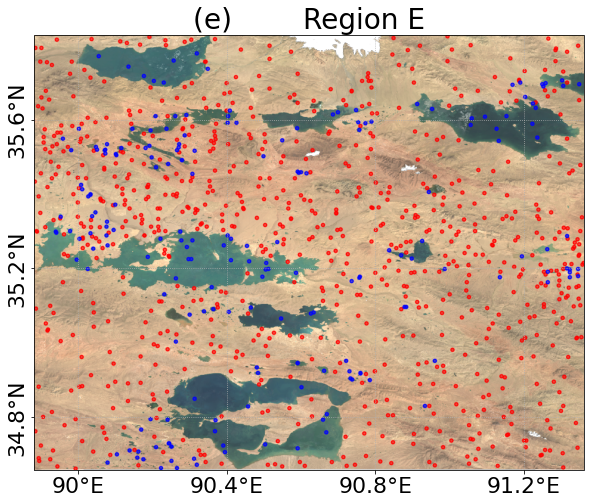

In [10]:
# 合成影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# # 大庆市
# region = 'daqing'
# sample_region = 'DAQING'
# re = [125.3055, 45.8362, 123.9355, 46.8762]
# # 天津市
# region = 'tianjin'
# sample_region = 'TIANJIN'
# re = [117.4944, 38.6272, 115.9244, 39.6372]
# # 武汉市
# region = 'wuhan'
# sample_region = 'WUHAN'
# re = [115.0993, 29.8642, 113.7393, 30.9242]
# # 珠三角
# region = 'prd'
# sample_region = 'PRD'
# re = [114.0514, 22.2347, 112.7614, 23.2547]
# 青藏高原
region = 'tibet'
sample_region = 'TIBET'
re = [91.3626, 34.6579, 89.8826, 35.8279]

fig = plt.figure(figsize=(12, 8))
refer_img = ee.Image('users/311605001111/basemap_image/' + region).visualize(**{'opacity':0.85})
# refer_img = image.visualize(**{'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4,'opacity':0.7})
manual_samples = ee.FeatureCollection('users/311605001111/man_samples_1000/' + sample_region + '2020')
print('manual-sample number:{}'.format(manual_samples.size().getInfo()))
nowater = manual_samples.filter(ee.Filter.eq('label',0)).draw('red')
water = manual_samples.filter(ee.Filter.eq('label',1)).draw('blue')
blend = refer_img.blend(nowater).blend(water)
Map.addLayer(blend, {}, "Blend")

ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=22)
ax.set_title(label = '(e)        Region E', fontsize=28)